In [40]:
import numpy as np

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset

from utils import read_air_passengers_csv, train_val_test_split
from utils_lstm import LSTMNet

YEAR_CUTOFFS = [1940, 1956, 1960]

In [41]:
df = read_air_passengers_csv()
df_train, df_val, df_test = train_val_test_split(df, YEAR_CUTOFFS)

# Transform from pandas dataframe to numpy array of shape (n, 1)
train = df_train[['#Passengers']].astype('float32').values
val = df_val[['#Passengers']].astype('float32').values

# mu, std = train.mean(), train.std()
# train_norm = (train - mu)/std
# val_norm = (val - mu)/std

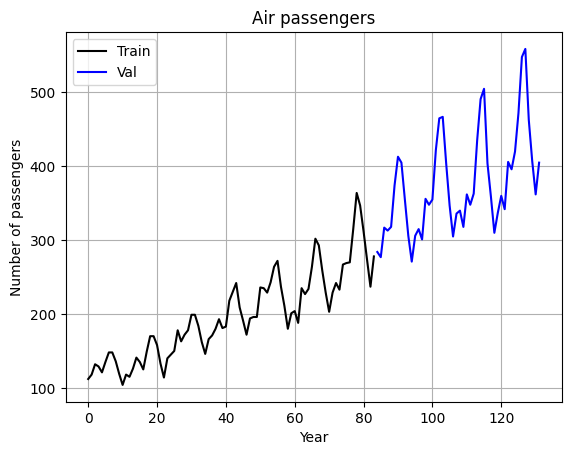

In [42]:
plt.title('Air passengers')
plt.xlabel('Year')
plt.ylabel('Number of passengers')
plt.plot(train, color='k', label='Train')
plt.plot(np.arange(len(train), len(train)+len(val)), val, color='b', label='Val')

plt.grid()
plt.legend()
plt.show()

In [43]:
# Constants

look_back = 1
recurrent_size = 50
n_layers = 1

batch_size = 8

n_epochs = 2000
n_epochs_val = n_epochs / 10

In [44]:
def create_dataset(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        feature = data[i:i+look_back]
        target = data[[i+look_back]]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [45]:
X_train, y_train = create_dataset(data=train, look_back=look_back)
X_val, y_val = create_dataset(data=val, look_back=look_back)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

torch.Size([83, 1, 1]) torch.Size([83, 1, 1])
torch.Size([47, 1, 1]) torch.Size([47, 1, 1])


In [46]:
train.shape

(84, 1)

In [29]:
train_dataloader = DataLoader(dataset=TensorDataset(X_train, y_train),
                              batch_size=batch_size,
                              shuffle=True)

model = LSTMNet(dim_input=1,
                dim_recurrent=recurrent_size,
                num_layers=n_layers,
                dim_output=1)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

for epoch in range(1, n_epochs + 1):
    # Set model to train mode
    model.train()
    for features, targets in train_dataloader:
        outputs = model(features)
        loss = criterion(outputs, targets)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % n_epochs_val == 0:
        # Set model to eval mode, and disable autograd
        model.eval()
        with torch.no_grad():
            # rmse_train = np.sqrt(criterion(model(X_train)*std + mu, y_train*std + mu))
            # rmse_val = np.sqrt(criterion(model(X_val)*std + mu, y_val*std + mu))
            rmse_train = np.sqrt(criterion(model(X_train), y_train))
            rmse_val = np.sqrt(criterion(model(X_val), y_val))
            print(f'Epoch {epoch}: RMSE_train = {rmse_train:.2f}, RMSE_val = {rmse_val:.2f}')

c:\Users\lopezmel\Documents\programming\python\tsa_air_passengers\.venv\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([8, 1, 1])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\lopezmel\Documents\programming\python\tsa_air_passengers\.venv\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([3, 1, 1])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\lopezmel\Documents\programming\python\tsa_air_passengers\.venv\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([83, 1, 1])) that is different to the

Epoch 200: RMSE_train = 169.80, RMSE_val = 346.33
Epoch 400: RMSE_train = 138.49, RMSE_val = 313.22
Epoch 600: RMSE_train = 109.97, RMSE_val = 281.75
Epoch 800: RMSE_train = 85.57, RMSE_val = 252.24
Epoch 1000: RMSE_train = 68.10, RMSE_val = 226.13
Epoch 1200: RMSE_train = 59.83, RMSE_val = 206.25
Epoch 1400: RMSE_train = 58.09, RMSE_val = 195.94
Epoch 1600: RMSE_train = 58.00, RMSE_val = 191.90
Epoch 1800: RMSE_train = 58.17, RMSE_val = 189.30
Epoch 2000: RMSE_train = 58.15, RMSE_val = 187.81


In [30]:
preds = []

model.eval()
with torch.no_grad():
    for i in range(len(train)-look_back):
        X_last = torch.tensor(train[i:i+look_back]).unsqueeze(0)
        new_pred = model(X_last)
        # Store only the value
        preds.append(new_pred.item())
    # X_last = torch.tensor(train_norm[-look_back:]).unsqueeze(0)
    for i in range(len(val)):
        new_pred = model(X_last)
        # Store only the value
        preds.append(new_pred.item())
        # Pass the tensor for next prediction
        X_last = torch.cat((X_last[:, -look_back+1:, :], new_pred.unsqueeze(0)), dim=1)

In [37]:
X_train.shape

torch.Size([92, 4, 1])

In [36]:
model(X_train).shape

torch.Size([92, 4, 1])

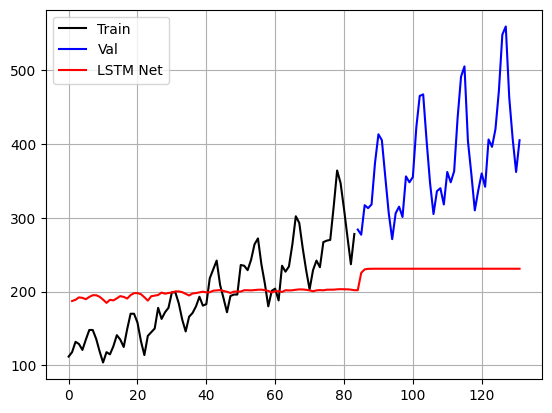

In [31]:
x_ticks_val = np.arange(len(train), len(train)+len(val))
x_ticks_preds = np.arange(1, len(train)+len(val))

plt.plot(train, c='k', label='Train')
plt.plot(x_ticks_val, val, c='b', label='Val')
plt.plot(x_ticks_preds, preds, c='r', label='LSTM Net')
plt.grid()
plt.legend()
plt.show()

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

df = pd.read_csv('data/AirPassengers.csv')
timeseries = df[["#Passengers"]].values.astype('float32')

# train-test split for time series
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

lookback = 4
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
X_train.shape

torch.Size([92, 4, 1])

In [39]:
train.shape

(96, 1)

In [ ]:
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries)
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()